In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from scipy.stats import zscore
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [23]:
# Load financial transactions dataset
file_path = "Expanded_Financial_Transactions.csv"
df = pd.read_csv(file_path)

# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Display first few rows
df.head()

,Date,Account,Amount,Type
0,2023-01-01,Cash,70951,Asset
1,2023-01-01,Salaries & Wages,-44259,Expense
2,2023-01-01,Short-Term Debt,-20655,Liability
3,2023-01-01,Inventory,74997,Asset
4,2023-01-01,Long-Term Debt,28768,Liability


In [30]:
# Aggregate and correct financial data
income = df[df["Type"] == "Income"].groupby("Date")["Amount"].sum().abs()  # Ensure revenue is positive
expenses = df[df["Type"] == "Expense"].groupby("Date")["Amount"].sum()
assets = df[df["Type"] == "Asset"].groupby("Date")["Amount"].sum()
liabilities = df[df["Type"] == "Liability"].groupby("Date")["Amount"].sum()

# Compute Net Income (Profit & Loss)
net_income = income.sum() + expenses.sum()

# Compute Total Equity
total_equity = assets.sum() + liabilities.sum()

# Print key financial metrics
print(f"Total Net Income: ${net_income:,.2f}")
print(f"Total Equity: ${total_equity:,.2f}")

Total Net Income: $25,588,411.00
Total Equity: $22,336,695.00


In [31]:
# Generate Income Statement
income_statement = df[df["Type"].isin(["Income", "Expense"])].groupby("Account")["Amount"].sum().reset_index()
display(income_statement)

,Account,Amount
0,Cost of Goods Sold,1810854
1,Depreciation,2780764
2,Dividends Paid,2920973
3,Interest Expense,1904540
4,Marketing Expense,2622642
5,Operating Expenses,2313978
6,Rent Expense,2128183
7,Revenue,2520871
8,Salaries & Wages,1705181
9,Tax Expense,2368100


In [32]:
# Generate Balance Sheet
balance_sheet = df[df["Type"].isin(["Asset", "Liability"])].groupby("Account")["Amount"].sum().reset_index()
display(balance_sheet)

,Account,Amount
0,Accounts Payable,1776551
1,Accounts Receivable,2052818
2,Accrued Liabilities,1971172
3,Cash,3015503
4,Inventory,2089675
5,Investments,2313113
6,Long-Term Debt,3156425
7,Prepaid Expenses,1970577
8,"Property, Plant & Equipment",2021028
9,Short-Term Debt,1969833


In [33]:
# Generate Cash Flow Statement
cash_flow_statement = df[df["Account"] == "Cash"].groupby("Date")["Amount"].sum().reset_index()
display(cash_flow_statement)

,Date,Amount
0,2023-01-01,70951
1,2023-01-02,94923
2,2023-01-04,-9458
3,2023-01-07,64444
4,2023-01-08,86304
...,...,...
91,2023-12-16,45408
92,2023-12-20,-48461
93,2023-12-22,-10440
94,2023-12-25,772


In [34]:
# Load budgeted data
try:
    budget = pd.read_csv("highly_detailed_budget_forecast.csv")
    budget.columns = ["Account", "Budgeted_Amount"]

    # Merge actual and budgeted financials
    variance_analysis = df.groupby("Account")["Amount"].sum().reset_index()
    variance_analysis = variance_analysis.merge(budget, on="Account", how="outer").fillna(0)

    # Calculate variance and percentage difference
    variance_analysis["Variance"] = variance_analysis["Amount"] - variance_analysis["Budgeted_Amount"]
    variance_analysis["% Difference"] = ((variance_analysis["Variance"] / variance_analysis["Budgeted_Amount"]) * 100).round(2)

    # Sort by largest variance
    variance_analysis = variance_analysis.sort_values(by="Variance", ascending=False)

    display(variance_analysis)
except FileNotFoundError:
    print("Budget file not found. Skipping variance analysis.")

,Account,Amount,Budgeted_Amount,Variance,% Difference
16,Retained Earnings,2936875.0,154460,2782415.0,1801.38
5,Depreciation,2780764.0,21462,2759302.0,12856.69
6,Dividends Paid,2920973.0,165375,2755598.0,1666.27
10,Long-Term Debt,3156425.0,586213,2570212.0,438.44
11,Marketing Expense,2622642.0,91894,2530748.0,2753.99
3,Cash,3015503.0,599437,2416066.0,403.06
20,Tax Expense,2368100.0,106106,2261994.0,2131.82
9,Investments,2313113.0,172573,2140540.0,1240.37
12,Operating Expenses,2313978.0,198369,2115609.0,1066.50
15,Rent Expense,2128183.0,93772,2034411.0,2169.53


In [35]:
# Ensure zero-division handling
total_income = income.sum() if income.sum() != 0 else np.nan
total_assets = assets.sum() if assets.sum() != 0 else np.nan
total_liabilities = liabilities.sum() if liabilities.sum() != 0 else np.nan
total_equity = total_assets + total_liabilities if total_assets and total_liabilities else np.nan

# Profitability Ratios
ROA = (net_income / total_assets) if total_assets else np.nan
ROE = (net_income / total_equity) if total_equity else np.nan

# Liquidity Ratios
current_ratio = total_assets / total_liabilities if total_liabilities else np.nan

# Debt Management
debt_to_equity = total_liabilities / total_equity if total_equity else np.nan

# Display Ratios
print(f"Return on Assets (ROA): {ROA:.2f}")
print(f"Return on Equity (ROE): {ROE:.2f}")
print(f"Current Ratio: {current_ratio:.2f}")
print(f"Debt-to-Equity Ratio: {debt_to_equity:.2f}")

Return on Assets (ROA): 1.90
Return on Equity (ROE): 1.15
Current Ratio: 1.52
Debt-to-Equity Ratio: 0.40


/Users/amatutuwaaosei-akoto/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


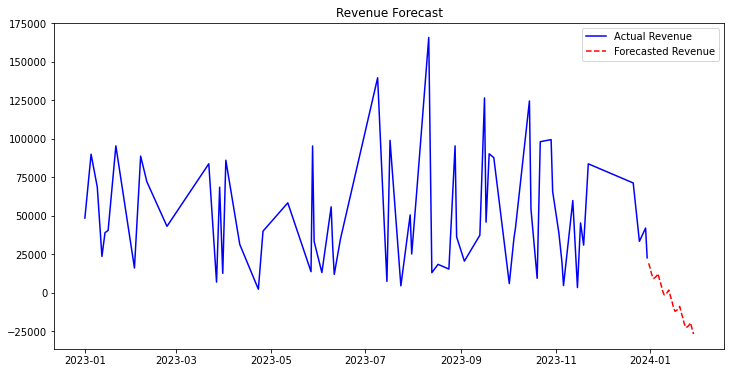

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ensure income data is not empty
if not income.empty:
    # Ensure income has a complete time index and fill missing dates
    income = income.asfreq("D").interpolate(method="linear")

    # Adjust seasonal periods dynamically (Use 7 for weekly seasonality if data is daily)
    seasonal_periods = min(7, len(income))  

    # Train an Exponential Smoothing model on revenue data (Set use_boxcox=False during model initialization)
    model = ExponentialSmoothing(
        income, trend="add", seasonal="add", seasonal_periods=seasonal_periods, use_boxcox=False
    )
    fit = model.fit(optimized=True, remove_bias=True)  # No use_boxcox here

    # Forecast future income for 30 days
    forecast_index = pd.date_range(start=income.index[-1], periods=31, freq="D")[1:]
    forecast_values = fit.forecast(30)

    # Convert forecast to a Pandas Series
    forecast = pd.Series(data=forecast_values, index=forecast_index)

    # Plot results
    plt.figure(figsize=(12, 6))

    # Convert Pandas Index to NumPy array before plotting
    plt.plot(income.index.to_numpy(), income.values, label="Actual Revenue", color="blue")
    plt.plot(forecast.index.to_numpy(), forecast.values, label="Forecasted Revenue", linestyle="dashed", color="red")

    plt.title("Revenue Forecast")
    plt.legend()
    plt.show()
else:
    print("Income data is empty. Cannot perform forecasting.")

In [42]:
scaler = StandardScaler()
df["Scaled_Amount"] = scaler.fit_transform(df[["Amount"]])

iso_forest = IsolationForest(contamination=0.02, random_state=42)
df["Anomaly_Score"] = iso_forest.fit_predict(df[["Scaled_Amount"]])

anomalies = df[df["Anomaly_Score"] == -1]
display(anomalies)

/Users/amatutuwaaosei-akoto/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Date,Account,Amount,Type,Scaled_Amount,Anomaly_Score
33,2023-01-05,Interest Expense,-49826,Expense,-1.716986,-1
62,2023-01-10,Cash,-49808,Asset,-1.716572,-1
73,2023-01-12,Revenue,-48927,Income,-1.696342,-1
158,2023-01-27,Cost of Goods Sold,-49713,Expense,-1.714391,-1
233,2023-02-09,Operating Expenses,-49610,Expense,-1.712026,-1
294,2023-02-21,Retained Earnings,-49113,Equity,-1.700613,-1
343,2023-03-01,Accounts Payable,-48816,Liability,-1.693794,-1
376,2023-03-07,Retained Earnings,99335,Equity,1.708123,-1
503,2023-04-05,Short-Term Debt,-49131,Liability,-1.701027,-1
529,2023-04-09,Cash,-48694,Asset,-1.690992,-1


In [43]:
with pd.ExcelWriter("Advanced_Financial_Report.xlsx") as writer:
    income_statement.to_excel(writer, sheet_name="Income Statement", index=False)
    balance_sheet.to_excel(writer, sheet_name="Balance Sheet", index=False)
    cash_flow_statement.to_excel(writer, sheet_name="Cash Flow Statement", index=False)
    variance_analysis.to_excel(writer, sheet_name="Variance Analysis", index=False)
    anomalies.to_excel(writer, sheet_name="Anomalies", index=False)

print("Financial Report successfully generated: Advanced_Financial_Report.xlsx")

Financial Report successfully generated: Advanced_Financial_Report.xlsx
